In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [3]:
dataset = "mnist"
algo = "modular"

experiment_folder = "experiment_results"
experiment_name = "jorge_setting_basis_no_sparse_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False"

use_contrastive = False
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = 2 # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)


In [4]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    module_selection_strategy = 'gt_most_similar'

    cfg.sharing_strategy = DictConfig({
        "name": "modmod",
        'num_coms_per_round': 2,
        'module_selection': module_selection_strategy,
        'sync_base': True,
        'opt_with_random': False,
        'freeze_candidate_module': False,
        # "transfer_decoder": True,
        "transfer_decoder": False,
        "transfer_structure": True,
    })
    # train_cfg['num_epochs'] = 1
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [5]:
fleet = setup_fleet(save_dir, parallel=parallel, modify_cfg=modify_cfg)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64', 'num_agents': 8, 'root_save_dir': 'experiment_results/jorge_setting_basis_no_sparse_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False', 'parallel': True, 'num_init_tasks': 4, 'overwrite': False, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}

INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Agent: node_id: 69420, seed: 69420000
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [6]:
task_id = 7
source_task_id = 4
agent = fleet.agents[0]
neighbor = fleet.agents[6]

In [7]:
fleet.load_records()
fleet.update_replay_buffers(task_id-1)
fleet.load_model_from_ckpoint(task_ids=task_id-1)

In [8]:
print(agent.net.decoder[task_id].bias)
print(neighbor.net.decoder[source_task_id].bias)

Parameter containing:
tensor([ 0.1099, -0.1078], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0772,  0.1350], device='cuda:0', requires_grad=True)


In [9]:
fleet.communicate(task_id=task_id, end_epoch=None, comm_freq=None, num_epochs=None)

In [10]:
agent.change_save_dir(f'test_transfer_decoder_{task_id}')
agent.agent.save_dir

'test_transfer_decoder_7'

In [11]:
neighbor.task_sims[agent.node_id]

[0, 0, 0, 0, 1.0, 0.0, 0, 0]

In [12]:
print(agent.train_kwargs['module_list'][0].bias)
print(neighbor.net.components[4].bias)

Parameter containing:
tensor([-0.1318,  0.0313,  0.1805,  0.0444, -0.0458, -0.0529, -0.0572,  0.1708,
         0.0859,  0.1542,  0.1896,  0.2006,  0.0477, -0.0060,  0.2633, -0.0870,
        -0.0781, -0.0672,  0.1536,  0.0204,  0.2346, -0.0214,  0.1878,  0.0437,
        -0.1230,  0.2080,  0.1923, -0.1151,  0.0331, -0.0794, -0.0886,  0.1899,
         0.0233,  0.1134,  0.1583,  0.0367, -0.0413, -0.1174, -0.0491,  0.0148,
        -0.0359,  0.0375,  0.1315,  0.0495, -0.0907, -0.1727, -0.0262,  0.0590,
        -0.1295,  0.0670,  0.1581, -0.0046, -0.0007, -0.1464, -0.0145, -0.0206,
         0.0379, -0.0890, -0.0117,  0.1375,  0.0281,  0.0406, -0.0277, -0.0685],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1318,  0.0313,  0.1805,  0.0444, -0.0458, -0.0529, -0.0572,  0.1708,
         0.0859,  0.1542,  0.1896,  0.2006,  0.0477, -0.0060,  0.2633, -0.0870,
        -0.0781, -0.0672,  0.1536,  0.0204,  0.2346, -0.0214,  0.1878,  0.0437,
        -0.1230,  0.2080,  0.19

Parameter containing:
tensor([[0.7326, 0.8848, 0.8536, 1.0129],
        [0.8586, 0.8330, 0.7690, 0.9831],
        [0.4714, 0.8061, 0.6182, 0.8249],
        [0.6434, 0.8731, 0.7682, 0.6985],
        [1.4692, 1.3610, 1.3343, 1.3260],
        [  -inf,   -inf,   -inf,   -inf]], device='cuda:0', requires_grad=True)


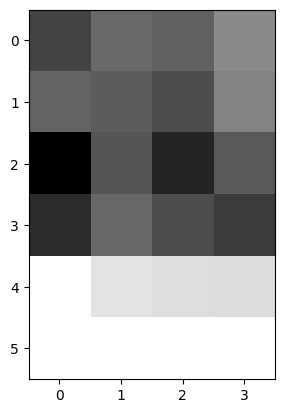

In [13]:
print(neighbor.net.structure[source_task_id])
plt.imshow(neighbor.net.structure[source_task_id].cpu().detach(), cmap='gray')

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], device='cuda:0', requires_grad=True)


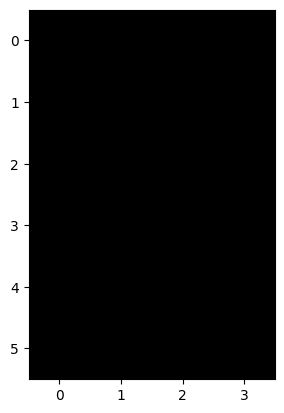

In [14]:
print(agent.net.structure[task_id])
plt.imshow(agent.net.structure[task_id].cpu().detach(), cmap='gray')

In [15]:
len(agent.net.components)

6

In [16]:
agent.net.structure[task_id]
neighbor.net.structure[source_task_id]

Parameter containing:
tensor([[0.7326, 0.8848, 0.8536, 1.0129],
        [0.8586, 0.8330, 0.7690, 0.9831],
        [0.4714, 0.8061, 0.6182, 0.8249],
        [0.6434, 0.8731, 0.7682, 0.6985],
        [1.4692, 1.3610, 1.3343, 1.3260],
        [  -inf,   -inf,   -inf,   -inf]], device='cuda:0', requires_grad=True)

In [17]:
agent.train(task_id)

INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.05708054	acc: 0.989
INFO:root:	task: 1	loss: 0.21490327	acc: 0.951
INFO:root:	task: 2	loss: 0.34293968	acc: 0.924
INFO:root:	task: 3	loss: 0.23171119	acc: 0.956
INFO:root:	task: 4	loss: 0.28780765	acc: 0.910
INFO:root:	task: 5	loss: 0.20492556	acc: 0.987
INFO:root:	task: 6	loss: 0.22748961	acc: 0.929
INFO:root:	task: 7	loss: 0.67599493	acc: 0.494
INFO:root:	task: avg	loss: 0.28035655	acc: 0.893
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.05708054	acc: 0.989
INFO:root:	task: 1	loss: 0.21490327	acc: 0.951
INFO:root:	task: 2	loss: 0.34293968	acc: 0.924
INFO:root:	task: 3	loss: 0.23171119	acc: 0.956
INFO:root:	task: 4	loss: 0.28780765	acc: 0.910
INFO:root:	task: 5	loss: 0.20492556	acc: 0.987
INFO:root:	task: 6	loss: 0.22748961	acc: 0.929
INFO:root:	task: 7	loss: 0.69096618	acc: 0.494
INFO:root:	task: avg	loss: 0.28222796	acc: 0.893
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.05708054

Parameter containing:
tensor([[ 0.9878,  0.5851,  0.5999,  0.8134],
        [ 0.6819,  1.1648,  1.1388,  1.2563],
        [ 0.2736,  0.5423,  0.3658,  0.5898],
        [ 0.4408,  0.6415,  0.5556,  0.4543],
        [-0.2526, -0.1641, -0.1304, -0.2060],
        [-0.2136,  0.0493,  0.2537,  0.2080],
        [ 1.6203,  1.4918,  1.4507,  1.4601]], device='cuda:0',
       requires_grad=True)


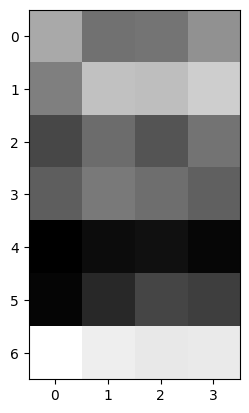

In [18]:
print(agent.net.structure[task_id])
plt.imshow(agent.net.structure[task_id].cpu().detach(), cmap='gray')

In [19]:
@torch.inference_mode()
def weird_eval_net_task(net, task, testloader, reverse_label=False):
    a = 0.
    n = len(testloader.dataset)
    for X, Y in testloader:
        if isinstance(X, list):
            X, _ = X
        X = X.to(net.device, non_blocking=True)
        Y = Y.to(net.device, non_blocking=True)
        Y_hat = net(X, task)
        if reverse_label:
            Y_hat = 1 - Y_hat
        a += (Y_hat.argmax(dim=1) == Y).sum().item()
    return a / n

In [20]:
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=256,
                                                         shuffle=False,
                                                         num_workers=4,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(agent.dataset.testset[:(task_id+1)])}


weird_eval_net_task(agent.net, task_id, testloaders[task_id], reverse_label=True)

0.041752577319587626

In [21]:
print(agent.net.decoder[task_id].bias)
print(neighbor.net.decoder[source_task_id].bias)

Parameter containing:
tensor([ 0.0926, -0.0905], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0772,  0.1350], device='cuda:0', requires_grad=True)


In [23]:
neighbor.net.structure[source_task_id]

Parameter containing:
tensor([[0.7326, 0.8848, 0.8536, 1.0129],
        [0.8586, 0.8330, 0.7690, 0.9831],
        [0.4714, 0.8061, 0.6182, 0.8249],
        [0.6434, 0.8731, 0.7682, 0.6985],
        [1.4692, 1.3610, 1.3343, 1.3260],
        [  -inf,   -inf,   -inf,   -inf]], device='cuda:0', requires_grad=True)

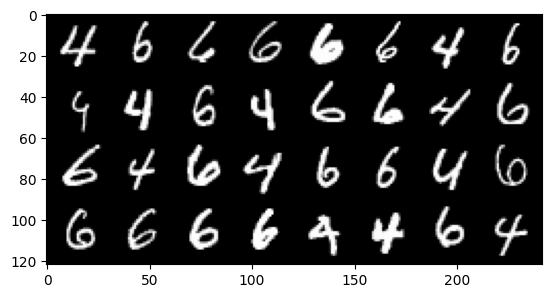

In [24]:
X, *_ = neighbor.agent.replay_buffers[source_task_id].get_tensors()
plt.imshow(make_grid(X).permute(1, 2, 0));

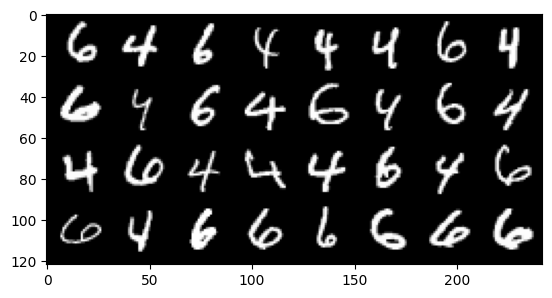

In [25]:
X, *_ = agent.agent.replay_buffers[task_id].get_tensors()
plt.imshow(make_grid(X).permute(1, 2, 0));

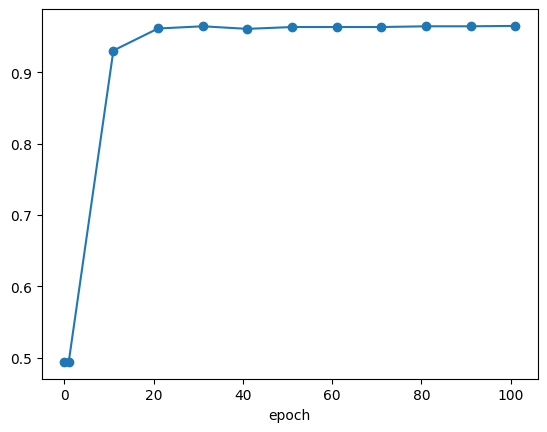

In [26]:
df = agent.agent.record.df
fig, ax = plt.subplots()
agg = df[df['test_task'] == task_id].groupby(['epoch']).mean(numeric_only=True)['test_acc']
agg.plot(ax=ax, label="Frozen",marker='o');

In [27]:
# compute AuC of agg
auc = np.trapz(agg, agg.index)
auc

94.14845360824742

## Problem



Transfer only module: AUC: 91.10463917525773

Module + structure: 94.47268041237115

Module + decoder: 81.31340206185567

Module + structure + decoder: 53.514175257731964


The problem lies in transferring the decoder. Because even if two tasks are identical, they can still be different up to some permutation. The network needs to spend a lot of time doing that permutation



Module + structure + decoder (with permutation): 97.46005154639175
